### Install packages

In [1]:
# !pip install -U pip
# !pip install -U setuptools wheel
# !pip install "numpy<2.0.0"  # Fix compatibility issue with AutoGluon
# !pip install -U "mxnet<2.0.0" bokeh==2.0.1
# !pip install autogluon --no-cache-dir
# !pip install kaggle

### Setup Kaggle API Key

In [2]:
# import os
# kaggle_dir = os.path.expanduser("~/.kaggle")
# !mkdir -p {kaggle_dir}
# !touch {kaggle_dir}/kaggle.json
# !chmod 600 {kaggle_dir}/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
# import json
# import os
# kaggle_username = "vbustillo"
# kaggle_key = "4a62006bdac26949783ce007d3ed2c8e"

# Save API token to the kaggle.json file in the user's home directory
# kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")
# with open(kaggle_path, "w") as f:
#     f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
# !kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
# !unzip -o bike-sharing-demand.zip -d input/

In [1]:
# Move existing data files to input directory (run this once if files are in current directory)
import os
import shutil

# Create directories if they don't exist
os.makedirs('input', exist_ok=True)
os.makedirs('submissions', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Move data files to input directory if they exist in current directory
data_files = ['train.csv', 'test.csv', 'sampleSubmission.csv']
for file in data_files:
    if os.path.exists(file) and not os.path.exists(f'input/{file}'):
        shutil.move(file, f'input/{file}')
        print(f"Moved {file} to input/{file}")
    elif os.path.exists(f'input/{file}'):
        print(f"input/{file} already exists")
    else:
        print(f"{file} not found - you may need to download it first")

print("\nDirectory structure created:")
print("- input/: Contains train.csv, test.csv, sampleSubmission.csv")
print("- models/: Will contain trained AutoGluon models")
print("- submissions/: Will contain generated submission files")

input/train.csv already exists
input/test.csv already exists
input/sampleSubmission.csv already exists

Directory structure created:
- input/: Contains train.csv, test.csv, sampleSubmission.csv
- models/: Will contain trained AutoGluon models
- submissions/: Will contain generated submission files


### Import Packages

In [2]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from modeling_pipeline import data_process, train_pipeline

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read data and transform it accordingly

In [3]:
train = pd.read_csv("input/train.csv", parse_dates=["datetime"])
test = pd.read_csv("input/test.csv", parse_dates=["datetime"])
submission = pd.read_csv("input/sampleSubmission.csv")

In [4]:
numerical_features = [
    'temp', 'atemp', 'humidity', 'windspeed'
]

categorical_features = [
    'season', 'holiday', 'workingday', 'weather',
    'hour', 'dayofweek', 'month',
    'is_morning', 'is_evening', 'is_night',
    'temp_quart', 'atemp_quart', 'humidity_quart', 'windspeed_quart'
    ,'meteo_bin'
]

In [5]:
train, test = data_process.numerical_to_quartiles(train, test, numerical_features)

train = data_process.enrich_featureset(train, categorical_features)
test = data_process.enrich_featureset(test, categorical_features)

train_log = data_process.create_log_transformed_data(train, target_col='count')
train_log = data_process.create_log_transformed_data(train_log, target_col='casual')
train_log = data_process.create_log_transformed_data(train_log, target_col='registered')

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/project/modeling_pipeline/data_process.py:275: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


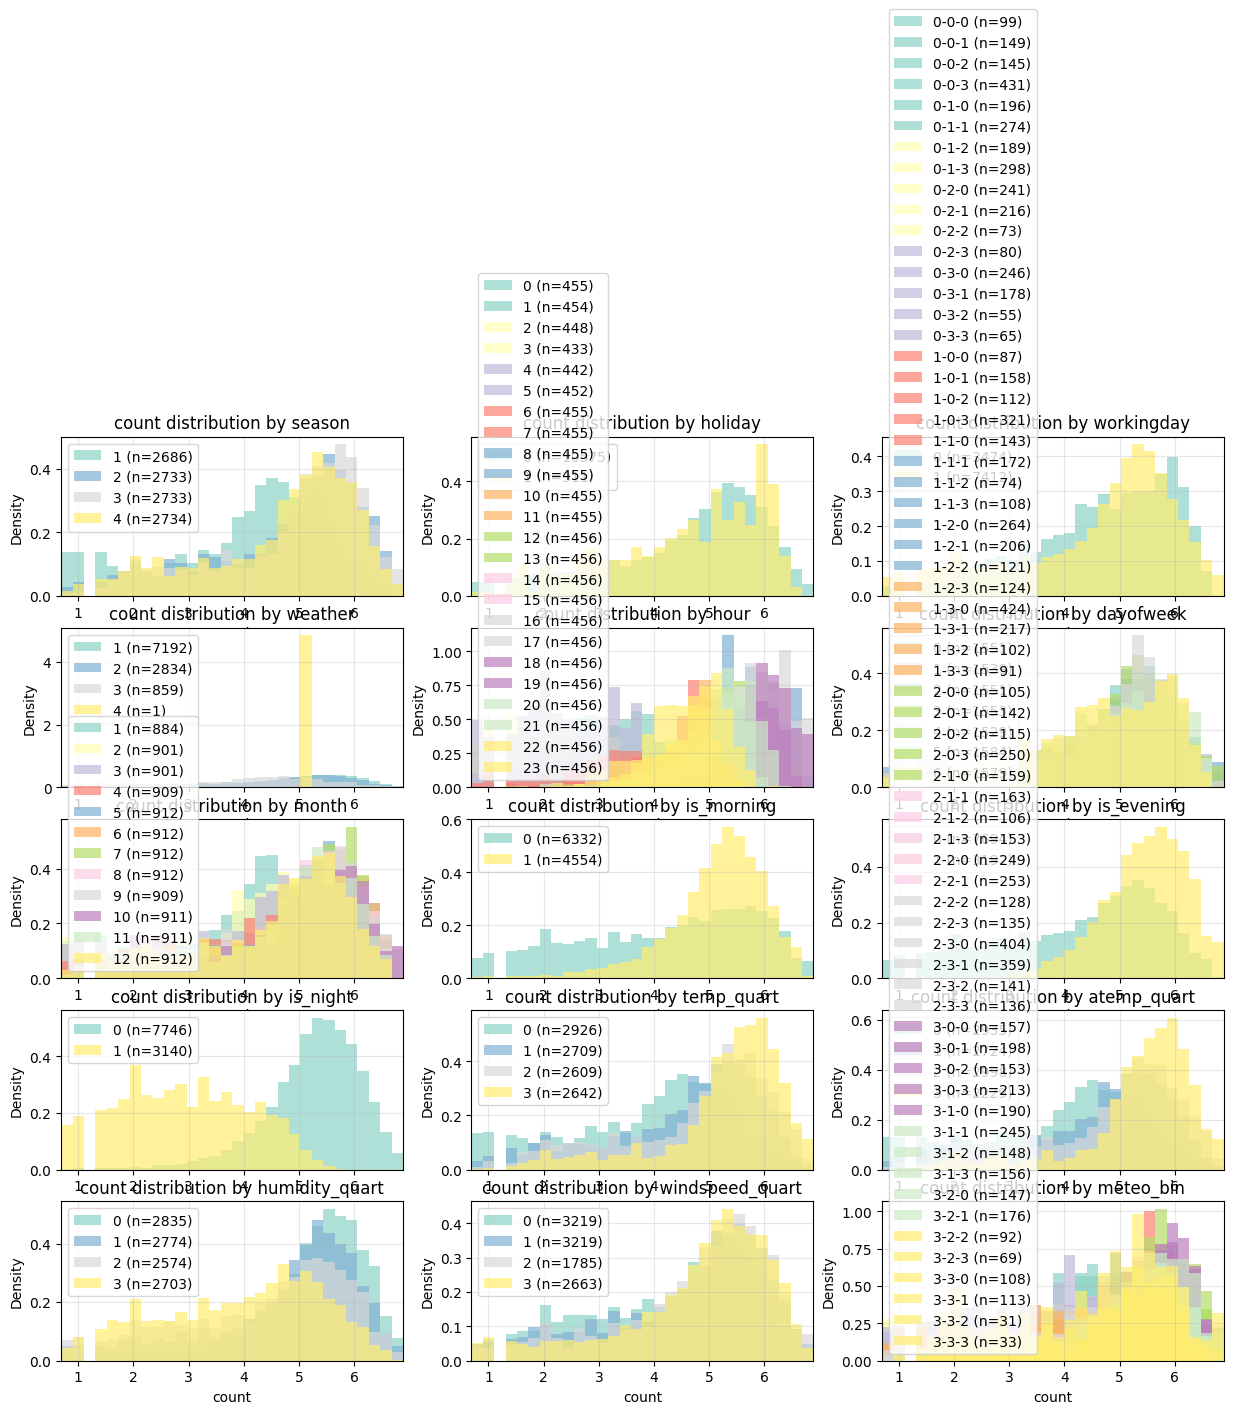

In [6]:
# Analyze target distribution across categorical features
data_process.plot_target_vs_categorical_features(
    df=train_log, 
    categorical_features=categorical_features, 
    target_col='count',
    figsize=(15, 12)
)

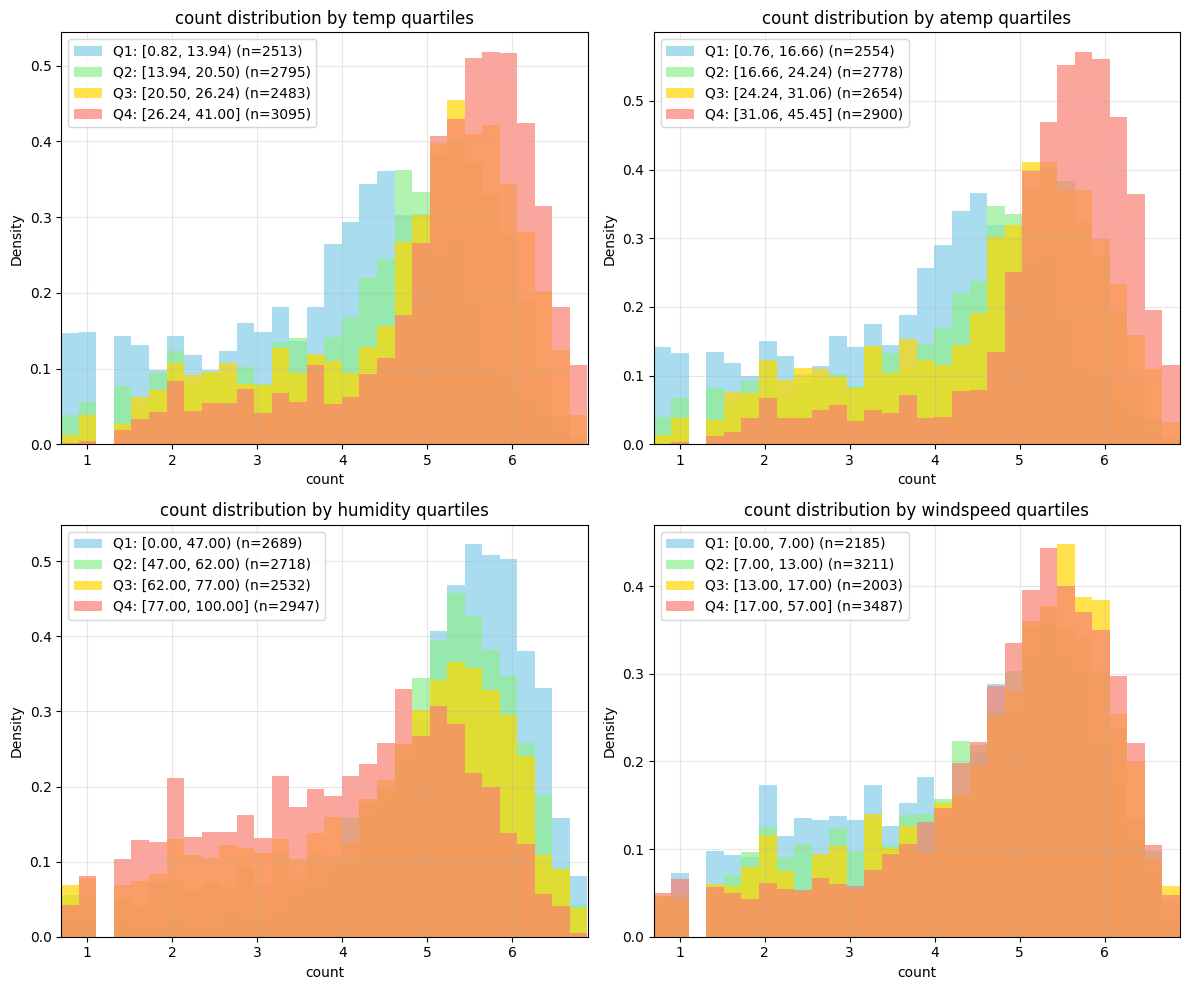

In [7]:
# Analyze target distribution across quartiles of numerical features
data_process.plot_target_vs_numerical_features_quartiles(
    df=train_log, 
    numerical_features=numerical_features, 
    target_col='count',
    figsize=(12, 10)
)

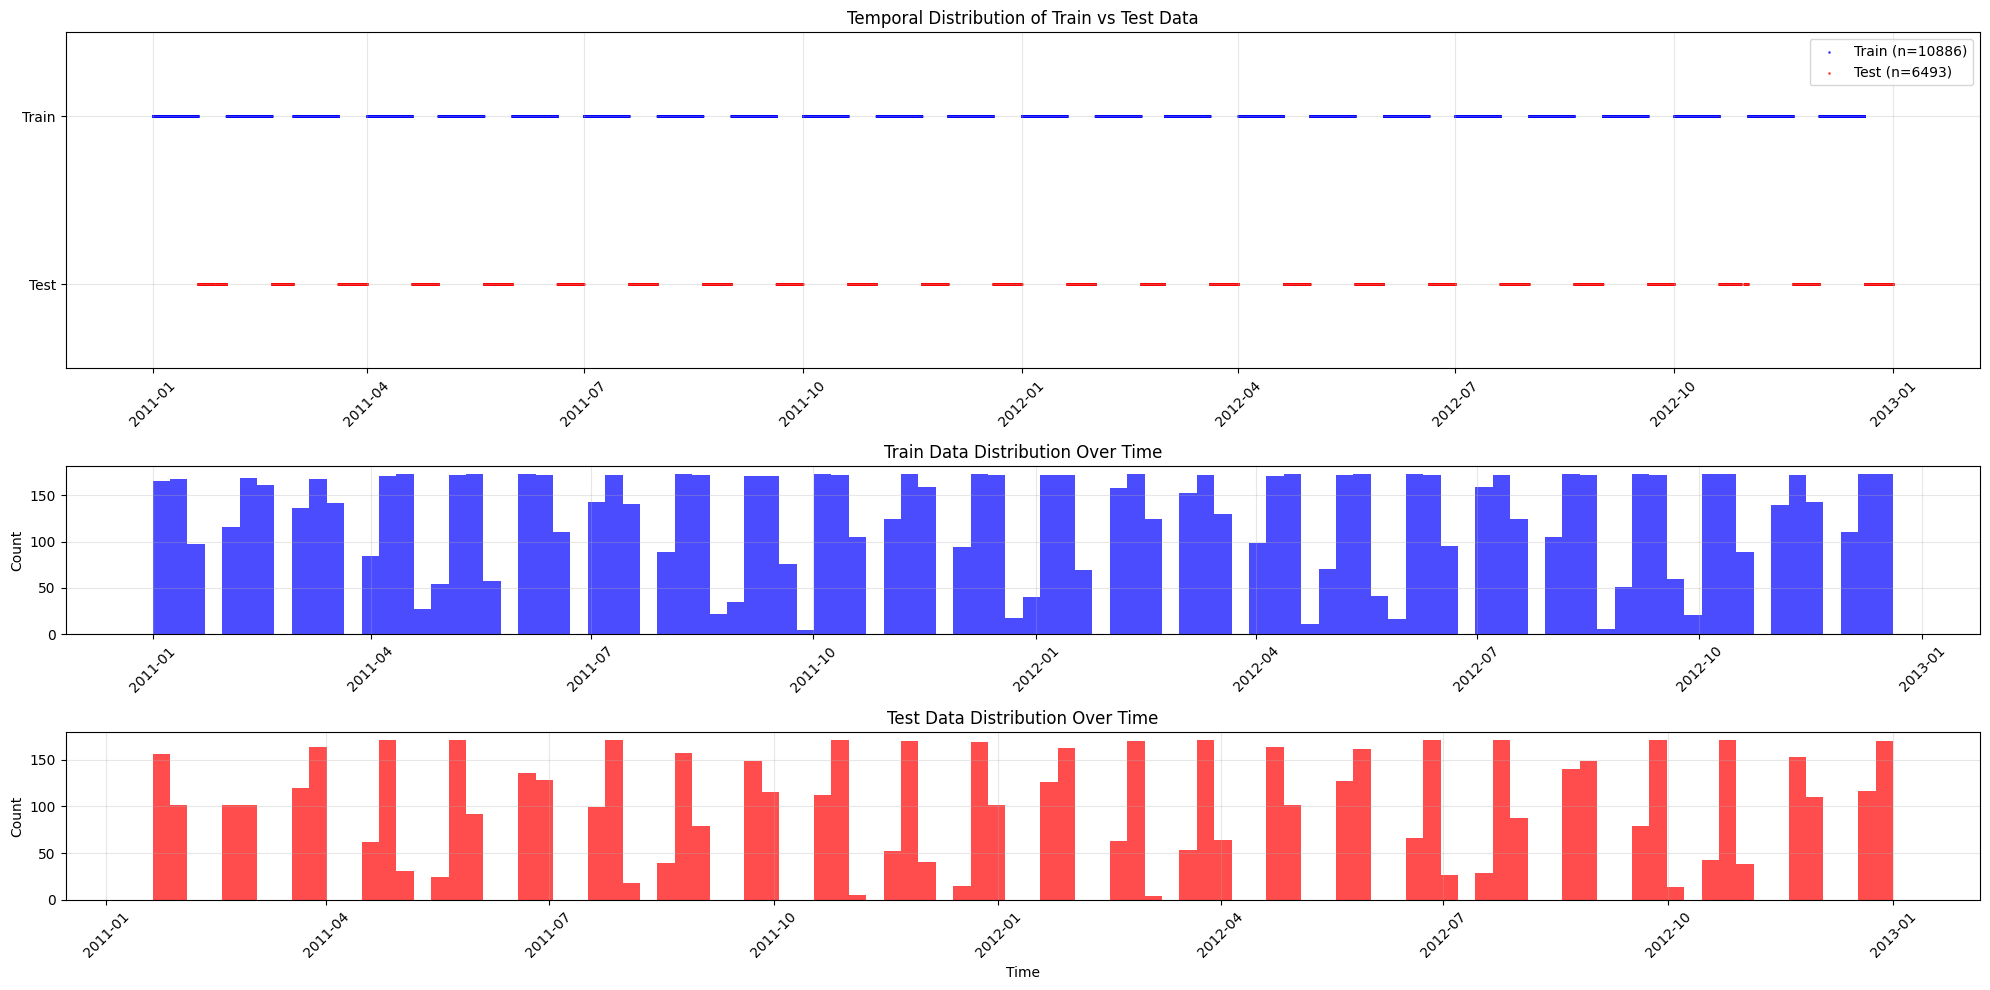

Temporal Data Summary:
Train data period: 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Test data period: 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Train duration: 718 days
Test duration: 711 days
Overlap period: 2011-01-20 00:00:00 to 2012-12-19 23:00:00
Overlap duration: 699 days
Train and test periods overlap or are adjacent


In [8]:
# Visualize temporal distribution of train vs test data
data_process.plot_temporal_data_distribution(
    train_df=train, 
    test_df=test, 
    datetime_col='datetime',
    figsize=(20, 10)
)

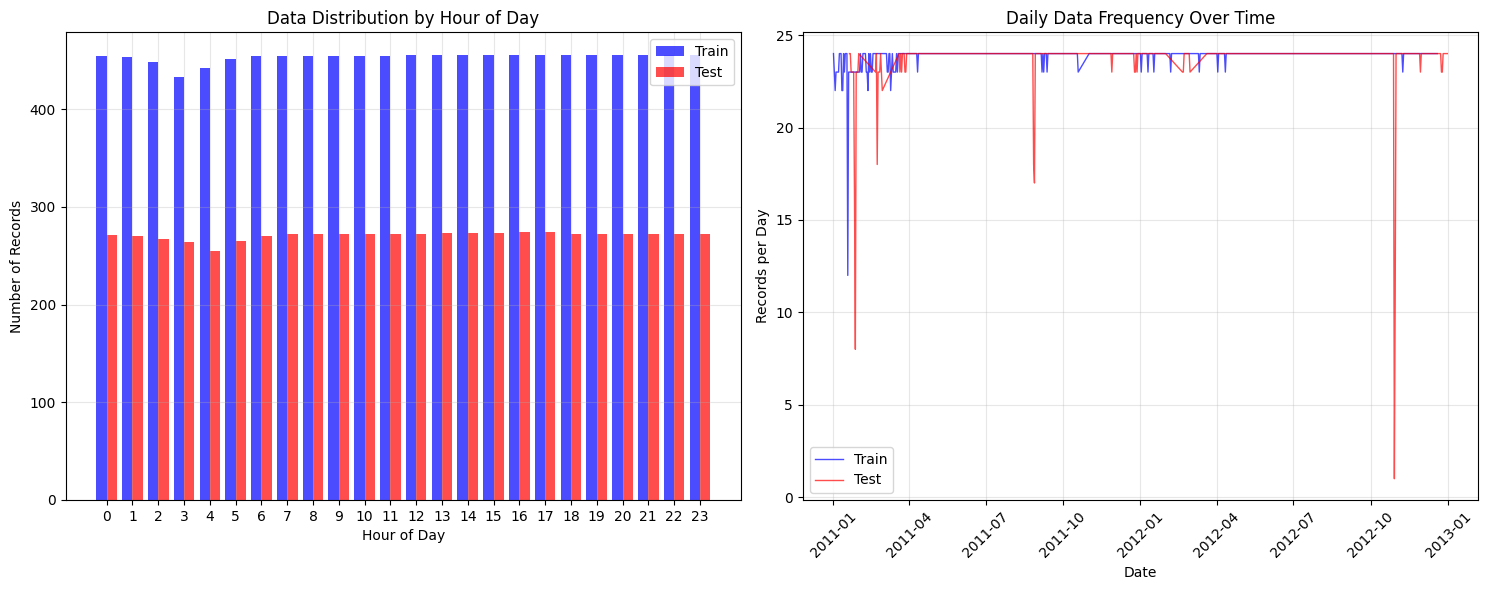

In [9]:
# Analyze hourly patterns in train vs test data
data_process.plot_hourly_patterns(
    train_df=train, 
    test_df=test, 
    datetime_col='datetime',
    figsize=(15, 6)
)

In [10]:
print("New features created and log transformation applied!")
print(f"Train shape: {train_log.shape}")
print(f"Test shape: {test.shape}")
print(f"Log-transformed target range: {train_log['count'].min():.4f} to {train_log['count'].max():.4f}")
print(f"Log-transformed target range: {train_log['casual'].min():.4f} to {train_log['casual'].max():.4f}")
print(f"Log-transformed target range: {train_log['registered'].min():.4f} to {train_log['registered'].max():.4f}")
train_log.head(3)

New features created and log transformation applied!
Train shape: (10886, 23)
Test shape: (6493, 20)
Log-transformed target range: 0.6931 to 6.8855
Log-transformed target range: 0.0000 to 5.9081
Log-transformed target range: 0.0000 to 6.7878


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,atemp_quart,humidity_quart,windspeed_quart,meteo_bin,hour,month,dayofweek,is_morning,is_evening,is_night
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,1.386294,...,0,3,0,0-3-0,0,1,5,0,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,2.197225,...,0,3,0,0-3-0,1,1,5,0,0,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,1.791759,...,0,3,0,0-3-0,2,1,5,0,0,1


### Time Lag Features

In [11]:
### Time Lag Features

# Create log-transformed lag features using data_process functions
print("Creating log-transformed lag features...")

# Create lag features for the count target variable
train_with_log_lags, test_with_log_lags = data_process.create_log_lag_features(
    train_df=train_log, 
    test_df=test, 
    target_col='count', 
    missing_value=-999
)

# Update the datasets
train_log = train_with_log_lags.copy()
test = test_with_log_lags.copy()

# Get the lag feature names
log_lag_features = data_process.get_log_lag_feature_names()

print(f"Created {len(log_lag_features)} log lag features:")
for feature in log_lag_features:
    print(f"  - {feature}")

# Update numerical features to include lag features
numerical_features = numerical_features + log_lag_features

print(f"\nUpdated feature configuration:")
print(f"Original numerical features: {numerical_features[:4]}")
print(f"Log lag features: {log_lag_features}")
print(f"Total numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

Creating log-transformed lag features...
Created 4 log lag features:
  - log_lag_1d
  - log_lag_2d
  - log_lag_7d
  - log_lag_14d

Updated feature configuration:
Original numerical features: ['temp', 'atemp', 'humidity', 'windspeed']
Log lag features: ['log_lag_1d', 'log_lag_2d', 'log_lag_7d', 'log_lag_14d']
Total numerical features: 8
Categorical features: 15


In [12]:
# Analyze lag feature coverage and correlations
data_process.analyze_lag_feature_coverage(
    df=train_log, 
    lag_features=log_lag_features, 
    title_prefix="Train "
)

data_process.analyze_lag_feature_coverage(
    df=test, 
    lag_features=log_lag_features, 
    title_prefix="Test "
)

# Calculate correlations with the target (before log transformation)
# correlations = data_process.calculate_lag_feature_correlations(
#     df=train_log, 
#     lag_features=log_lag_features, 
#     target_col='count'
# )


Train Lag Feature Coverage Analysis:
log_lag_1d:
  Available: 10,265 (94.3%)
  Missing: 621 (5.7%)
  Mean: 4.6015, Std: 1.4115

log_lag_2d:
  Available: 9,701 (89.1%)
  Missing: 1,185 (10.9%)
  Mean: 4.5991, Std: 1.4136

log_lag_7d:
  Available: 6,844 (62.9%)
  Missing: 4,042 (37.1%)
  Mean: 4.5822, Std: 1.4151

log_lag_14d:
  Available: 4,249 (39.0%)
  Missing: 6,637 (61.0%)
  Mean: 4.5983, Std: 1.3992


Test Lag Feature Coverage Analysis:
log_lag_1d:
  Available: 572 (8.8%)
  Missing: 5,921 (91.2%)
  Mean: 4.6270, Std: 1.3909

log_lag_2d:
  Available: 1,133 (17.4%)
  Missing: 5,360 (82.6%)
  Mean: 4.6407, Std: 1.3778

log_lag_7d:
  Available: 3,983 (61.3%)
  Missing: 2,510 (38.7%)
  Mean: 4.6455, Std: 1.3904

log_lag_14d:
  Available: 6,470 (99.6%)
  Missing: 23 (0.4%)
  Mean: 4.6117, Std: 1.4091



## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

### Train General model (registered + casual)

In [30]:
predictor_general = train_pipeline.regression_autogluon(
    train_df=train_log,
    feature_cols=categorical_features + numerical_features,
    target_col='count',
    time_limit=2100,
    path='models/bike_sharing_general_v03'
)

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. T

In [31]:
# Make predictions with the new feature model
predictions_log_general = predictor_general.predict(test, as_pandas=True)

# Transform predictions back from log space
predictions_general = data_process.inverse_log_transform(predictions_log_general)

print(f"Predictions range: {predictions_general.min():.2f} to {predictions_general.max():.2f}")


Predictions range: 1.63 to 845.67


In [32]:
predictor_general.fit_summary(verbosity=1, show_plot=False)

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3  -0.293246  root_mean_squared_error      23.326460  784.198154                0.000273           0.060375            3       True         28
1       ExtraTrees_2_BAG_L2  -0.294429  root_mean_squared_error      23.036048  562.429236                3.829233          13.164544            2       True         23
2         CatBoost_2_BAG_L2  -0.294632  root_mean_squared_error      19.328844  653.528132                0.122029         104.263440            2       True         21
3           CatBoost_BAG_L2  -0.294757  root_mean_squared_error      19.374925  666.709795                0.168110         117.445104            2       True         20
4         ExtraTrees_BAG_L2  -0.295097  root_mean_squared_error      22.830579  559.129635   

{'model_types': {'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForest_2_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForest_3_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForest_4_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'CatBoost_2_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTrees_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTrees_2_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_2_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_3_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'RandomForest_2_BAG_L2': 'StackerEnsembleModel_RF',
  'RandomForest_3_BAG_L2': 'St

In [38]:
# Create submission dataframe for new features model
submission_general = pd.read_csv('input/sampleSubmission.csv')
submission_general["count"] = predictions_general
submission_general.to_csv("submissions/submission_gen_new_ft_and_laggs_bis_bis.csv", index=False)

In [39]:
!kaggle competitions submit -c bike-sharing-demand -f submissions/submission_gen_new_ft_and_laggs_bis_bis.csv -m "clean pipeline new features with laggs bis bis"

100%|████████████████████████████████████████| 188k/188k [00:05<00:00, 34.5kB/s]
Successfully submitted to Bike Sharing Demand

In [40]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                     date                        description                                     status                     publicScore  privateScore  
-------------------------------------------  --------------------------  ----------------------------------------------  -------------------------  -----------  ------------  
submission_gen_new_ft_and_laggs_bis_bis.csv  2025-07-29 22:13:48         clean pipeline new features with laggs bis bis  SubmissionStatus.COMPLETE  0.41980      0.41980       
submission_combined_tuned_def.csv            2025-07-29 16:22:18.653000  combined predictions tuned def.                 SubmissionStatus.COMPLETE  0.42084      0.42084       
submission_gen_new_ft_and_laggs_bis.csv      2025-07-29 15:25:22         clean pipeline new features with laggs bis      SubmissionStatus.COMPLETE  0.41909      0.41909       
submission_gen_new_ft_and_laggs.csv          2025-07-29 14:50:38         clean pipeline new features with laggs         

### Train individual models (registered and casual)

In [25]:
predictor_registered = train_pipeline.regression_autogluon(
    train_df=train_log,
    feature_cols=categorical_features + numerical_features,
    target_col='registered',
    time_limit=1800,
    path='models/bike_sharing_registered'
)

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. T

In [26]:
predictor_casual = train_pipeline.regression_autogluon(
    train_df=train_log,
    feature_cols=categorical_features + numerical_features,
    target_col='casual',
    time_limit=1800,
    path='models/bike_sharing_casual'
)

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. T

In [27]:
# Make predictions with the new feature model
predictions_log_registered = predictor_registered.predict(test, as_pandas=True)
predictions_log_casual = predictor_casual.predict(test, as_pandas=True)

# Transform predictions back from log space
predictions_registered = data_process.inverse_log_transform(predictions_log_registered)
predictions_casual = data_process.inverse_log_transform(predictions_log_casual)

print(f"Predictions range: {predictions_registered.min():.2f} to {predictions_registered.max():.2f}")
print(f"Predictions range: {predictions_casual.min():.2f} to {predictions_casual.max():.2f}")

predictions_final = predictions_registered + predictions_casual
print(f"Final predictions range: {predictions_final.min():.2f} to {predictions_final.max():.2f}")

Predictions range: 1.42 to 732.73
Predictions range: 0.02 to 277.17
Final predictions range: 1.51 to 834.04


In [28]:
# Create submission dataframe for new features model
submission_combined = pd.read_csv('input/sampleSubmission.csv')
submission_combined["count"] = predictions_final
submission_combined.to_csv("submissions/submission_combined_tuned_def.csv", index=False)

In [29]:
!kaggle competitions submit -c bike-sharing-demand -f submissions/submission_combined_tuned_def.csv -m "combined predictions tuned def."

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 72.9kB/s]
Successfully submitted to Bike Sharing Demand

In [37]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                        description                                status                     publicScore  privateScore  
------------------------------  --------------------------  -----------------------------------------  -------------------------  -----------  ------------  
submission_combined.csv         2025-07-27 10:27:05         combined predictions submission            SubmissionStatus.COMPLETE  0.43917      0.43917       
submission_general.csv          2025-07-27 10:01:14.297000  clean pipeline submission                  SubmissionStatus.COMPLETE  0.43654      0.43654       
submission_general.csv          2025-07-27 09:37:25.157000  clean pipeline submission                  SubmissionStatus.COMPLETE  0.43654      0.43654       
submission_clean_nb.csv         2025-07-26 20:53:13         clean notebook                             SubmissionStatus.COMPLETE  0.41055      0.41055       
